# Imports

In [187]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_squared_log_error, make_scorer
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import PowerTransformer
import warnings
warnings.filterwarnings('ignore')

# Read the Data.

In [2]:
data = pd.read_excel('Data_Train.xlsx')
data.head()

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price
0,The Prisoner's Gold (The Hunters 3),Chris Kuzneski,"Paperback,– 10 Mar 2016",4.0 out of 5 stars,8 customer reviews,THE HUNTERS return in their third brilliant no...,Action & Adventure (Books),Action & Adventure,220.00
1,Guru Dutt: A Tragedy in Three Acts,Arun Khopkar,"Paperback,– 7 Nov 2012",3.9 out of 5 stars,14 customer reviews,A layered portrait of a troubled genius for wh...,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93
2,Leviathan (Penguin Classics),Thomas Hobbes,"Paperback,– 25 Feb 1982",4.8 out of 5 stars,6 customer reviews,"""During the time men live without a common Pow...",International Relations,Humour,299.00
3,A Pocket Full of Rye (Miss Marple),Agatha Christie,"Paperback,– 5 Oct 2017",4.1 out of 5 stars,13 customer reviews,A handful of grain is found in the pocket of a...,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00
4,LIFE 70 Years of Extraordinary Photography,Editors of Life,"Hardcover,– 10 Oct 2006",5.0 out of 5 stars,1 customer review,"For seven decades, ""Life"" has been thrilling t...",Photography Textbooks,"Arts, Film & Photography",965.62


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6237 entries, 0 to 6236
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Title         6237 non-null   object 
 1   Author        6237 non-null   object 
 2   Edition       6237 non-null   object 
 3   Reviews       6237 non-null   object 
 4   Ratings       6237 non-null   object 
 5   Synopsis      6237 non-null   object 
 6   Genre         6237 non-null   object 
 7   BookCategory  6237 non-null   object 
 8   Price         6237 non-null   float64
dtypes: float64(1), object(8)
memory usage: 438.7+ KB


In [4]:
data.nunique()

Title           5568
Author          3679
Edition         3370
Reviews           36
Ratings          342
Synopsis        5549
Genre            345
BookCategory      11
Price           1614
dtype: int64

In [5]:
data['Author'].value_counts() == 1

Agatha Christie    False
Ladybird           False
DK                 False
Albert Uderzo      False
Herge              False
                   ...  
Kenneth Roman       True
Y.V. Reddy          True
Ranade              True
Tehmina Durrani     True
Edgar H. Schein     True
Name: Author, Length: 3679, dtype: bool

In [6]:
data['Author'].value_counts()[data['Author'].value_counts() == 1]

E A Stokoe                  1
Woody Allen                 1
Gupta, R.K                  1
John Little, Doug Mcguff    1
Yasser Seirawan             1
                           ..
Kenneth Roman               1
Y.V. Reddy                  1
Ranade                      1
Tehmina Durrani             1
Edgar H. Schein             1
Name: Author, Length: 2791, dtype: int64

### No missing values in the dataset

In [7]:
len(data['Author'].value_counts()[data['Author'].value_counts() == 1])

2791

In [8]:
len(data['Author'].value_counts()[data['Author'].value_counts() == 1]) / len(data)

0.44749078082411414

#### 44% Authors are occur one time. 
There are 44% authors who has only one book ['Title]'] in the dataset.

In [9]:
len(data['Author'].unique()) / len(data)

0.5898669232002566

### unique authors are 59%

In [10]:
data['Author'].unique()

array(['Chris Kuzneski', 'Arun Khopkar', 'Thomas Hobbes', ...,
       'Saba Naqvi', 'Tom Phillips', 'Stephenie Meyer'], dtype=object)

## Checking duplicate

In [11]:
len(data) - len(data['Title'].unique())

669

In [12]:
data[data.duplicated()]

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price


In [13]:
data[data['Title'].duplicated()]

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price
208,Men Without Women: Stories,Haruki Murakami,"Paperback,– Import, 27 Sep 2018",4.1 out of 5 stars,93 customer reviews,THE SUNDAY TIMES BESTSELLER\n\nA dazzling new ...,Action & Adventure (Books),Action & Adventure,304.0
453,"Supreme Whispers: Supreme Court Judges, 1980-90",Abhinav Chandrachud,"Hardcover,– 30 May 2018",4.6 out of 5 stars,10 customer reviews,"In 1980, a brilliant young American scholar, G...","Arts History, Theory & Criticism (Books)","Biographies, Diaries & True Accounts",350.0
487,No-Drama Discipline: The Whole-Brain Way to Ca...,Daniel J. Siegel,"Hardcover,– 23 Sep 2014",5.0 out of 5 stars,8 customer reviews,NEW YORK TIMES BESTSELLER • The pioneering exp...,Action & Adventure (Books),Action & Adventure,514.4
668,The Emergency: A Personal History,Coomi Kapoor,"Paperback,– 16 Jun 2016",4.4 out of 5 stars,97 customer reviews,A searing indictment of the suspension of demo...,Literature,"Language, Linguistics & Writing",427.0
682,Atank Se Samjhauta,Dr. Praveen Tiwari,"Paperback,– 18 Mar 2019",5.0 out of 5 stars,7 customer reviews,"Saffron terrorism.\nIs it a fact? Or, is this ...",Action & Adventure (Books),Action & Adventure,256.0
...,...,...,...,...,...,...,...,...,...
6224,Asterix and the Goths: Album 3,Albert Uderzo,"Paperback,– 21 Apr 2005",3.8 out of 5 stars,6 customer reviews,Asterix and Obelix escort Getafix to the druid...,Mangas,Comics & Mangas,296.0
6225,Dragon Masters #2: Saving the Sun Dragon,Tracey West,"Paperback,– 14 May 2015",4.6 out of 5 stars,3 customer reviews,"Dragon Masters has it all--dragons, Dragon Sto...",Action & Adventure (Books),Action & Adventure,300.0
6226,Bhagwaan Ke Pakwaan: Food of the Gods,Devang Singh,"Paperback,– 4 Feb 2019",3.7 out of 5 stars,8 customer reviews,The rice beer bellies of a Christian village i...,Food & Lodging,Humour,358.0
6229,A Legacy of Spies,John le Carré,"Paperback,– 4 Oct 2017",4.1 out of 5 stars,29 customer reviews,"Peter Guillam, staunch colleague and disciple ...",Action & Adventure (Books),Action & Adventure,295.0


In [14]:
data[data['Title'] == 'Men Without Women: Stories']

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price
72,Men Without Women: Stories,Haruki Murakami,"Paperback,– Import, 27 Sep 2018",4.1 out of 5 stars,95 customer reviews,THE SUNDAY TIMES BESTSELLER\n\nA dazzling new ...,Action & Adventure (Books),Action & Adventure,304.0
208,Men Without Women: Stories,Haruki Murakami,"Paperback,– Import, 27 Sep 2018",4.1 out of 5 stars,93 customer reviews,THE SUNDAY TIMES BESTSELLER\n\nA dazzling new ...,Action & Adventure (Books),Action & Adventure,304.0


In [15]:
data[data['Title'] == 'Asterix and the Goths: Album 3']

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price
459,Asterix and the Goths: Album 3,Albert Uderzo,"Paperback,– 21 Apr 2005",3.8 out of 5 stars,6 customer reviews,Asterix and Obelix escort Getafix to the druid...,Mangas,Humour,355.0
6224,Asterix and the Goths: Album 3,Albert Uderzo,"Paperback,– 21 Apr 2005",3.8 out of 5 stars,6 customer reviews,Asterix and Obelix escort Getafix to the druid...,Mangas,Comics & Mangas,296.0


In [16]:
data[data['Title'] == 'The Emergency: A Personal History']

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price
51,The Emergency: A Personal History,Coomi Kapoor,"Paperback,– 16 Jun 2016",4.4 out of 5 stars,97 customer reviews,A searing indictment of the suspension of demo...,Literature,"Biographies, Diaries & True Accounts",427.0
668,The Emergency: A Personal History,Coomi Kapoor,"Paperback,– 16 Jun 2016",4.4 out of 5 stars,97 customer reviews,A searing indictment of the suspension of demo...,Literature,"Language, Linguistics & Writing",427.0


In [17]:
data[data['Title'] == 'Dragon Masters #2: Saving the Sun Dragon']

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price
3997,Dragon Masters #2: Saving the Sun Dragon,Tracey West,"Paperback,– 14 May 2015",4.6 out of 5 stars,3 customer reviews,"Dragon Masters has it all--dragons, Dragon Sto...",Action & Adventure (Books),Action & Adventure,175.0
6225,Dragon Masters #2: Saving the Sun Dragon,Tracey West,"Paperback,– 14 May 2015",4.6 out of 5 stars,3 customer reviews,"Dragon Masters has it all--dragons, Dragon Sto...",Action & Adventure (Books),Action & Adventure,300.0


In [18]:
data[data['Title'] == 'A Legacy of Spies']

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price
571,A Legacy of Spies,John le Carré,"Paperback,– 4 Oct 2017",4.1 out of 5 stars,29 customer reviews,"Peter Guillam, staunch colleague and disciple ...",Action & Adventure (Books),Politics,295.0
6229,A Legacy of Spies,John le Carré,"Paperback,– 4 Oct 2017",4.1 out of 5 stars,29 customer reviews,"Peter Guillam, staunch colleague and disciple ...",Action & Adventure (Books),Action & Adventure,295.0


In [19]:
data[data['Title'] == 'Gone Girl']

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price
2980,Gone Girl,Gillian Flynn,"Paperback,– 8 Nov 2012",4.1 out of 5 stars,407 customer reviews,About The Book\nGone Girl is a novel written b...,Contemporary Fiction (Books),"Crime, Thriller & Mystery",300.0
6231,Gone Girl,Gillian Flynn,"Paperback,– 3 Jan 2013",4.1 out of 5 stars,407 customer reviews,THE ADDICTIVE No.1 BESTSELLER AND INTERNATIONA...,Romance (Books),Romance,227.0


In [20]:
data[data.duplicated(subset = ['Title','Author','Edition'])]

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price
208,Men Without Women: Stories,Haruki Murakami,"Paperback,– Import, 27 Sep 2018",4.1 out of 5 stars,93 customer reviews,THE SUNDAY TIMES BESTSELLER\n\nA dazzling new ...,Action & Adventure (Books),Action & Adventure,304.0
453,"Supreme Whispers: Supreme Court Judges, 1980-90",Abhinav Chandrachud,"Hardcover,– 30 May 2018",4.6 out of 5 stars,10 customer reviews,"In 1980, a brilliant young American scholar, G...","Arts History, Theory & Criticism (Books)","Biographies, Diaries & True Accounts",350.0
487,No-Drama Discipline: The Whole-Brain Way to Ca...,Daniel J. Siegel,"Hardcover,– 23 Sep 2014",5.0 out of 5 stars,8 customer reviews,NEW YORK TIMES BESTSELLER • The pioneering exp...,Action & Adventure (Books),Action & Adventure,514.4
668,The Emergency: A Personal History,Coomi Kapoor,"Paperback,– 16 Jun 2016",4.4 out of 5 stars,97 customer reviews,A searing indictment of the suspension of demo...,Literature,"Language, Linguistics & Writing",427.0
682,Atank Se Samjhauta,Dr. Praveen Tiwari,"Paperback,– 18 Mar 2019",5.0 out of 5 stars,7 customer reviews,"Saffron terrorism.\nIs it a fact? Or, is this ...",Action & Adventure (Books),Action & Adventure,256.0
...,...,...,...,...,...,...,...,...,...
6216,The Bridget Jones Omnibus: The Singleton Years,Helen Fielding,"Paperback,– 20 Jun 2013",4.4 out of 5 stars,2 customer reviews,A dazzling urban satire of modern relationship...,Romance (Books),Romance,245.0
6224,Asterix and the Goths: Album 3,Albert Uderzo,"Paperback,– 21 Apr 2005",3.8 out of 5 stars,6 customer reviews,Asterix and Obelix escort Getafix to the druid...,Mangas,Comics & Mangas,296.0
6225,Dragon Masters #2: Saving the Sun Dragon,Tracey West,"Paperback,– 14 May 2015",4.6 out of 5 stars,3 customer reviews,"Dragon Masters has it all--dragons, Dragon Sto...",Action & Adventure (Books),Action & Adventure,300.0
6226,Bhagwaan Ke Pakwaan: Food of the Gods,Devang Singh,"Paperback,– 4 Feb 2019",3.7 out of 5 stars,8 customer reviews,The rice beer bellies of a Christian village i...,Food & Lodging,Humour,358.0


##### If Title, Author, and Edition is same then we'll consider that row is duplicate. we'll drop duplicate.

In [21]:
data_duplicate_removed = data.drop_duplicates(subset = ['Title','Author','Edition'])
len(data_duplicate_removed)

5606

### creating two seperate column from Edition column -- Type and Date

In [22]:
data_duplicate_removed[['Type','Date']] = data_duplicate_removed['Edition'].str.split(',– ',expand=True)

In [23]:
data_duplicate_removed.head()

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price,Type,Date
0,The Prisoner's Gold (The Hunters 3),Chris Kuzneski,"Paperback,– 10 Mar 2016",4.0 out of 5 stars,8 customer reviews,THE HUNTERS return in their third brilliant no...,Action & Adventure (Books),Action & Adventure,220.00,Paperback,10 Mar 2016
1,Guru Dutt: A Tragedy in Three Acts,Arun Khopkar,"Paperback,– 7 Nov 2012",3.9 out of 5 stars,14 customer reviews,A layered portrait of a troubled genius for wh...,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93,Paperback,7 Nov 2012
2,Leviathan (Penguin Classics),Thomas Hobbes,"Paperback,– 25 Feb 1982",4.8 out of 5 stars,6 customer reviews,"""During the time men live without a common Pow...",International Relations,Humour,299.00,Paperback,25 Feb 1982
3,A Pocket Full of Rye (Miss Marple),Agatha Christie,"Paperback,– 5 Oct 2017",4.1 out of 5 stars,13 customer reviews,A handful of grain is found in the pocket of a...,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00,Paperback,5 Oct 2017
4,LIFE 70 Years of Extraordinary Photography,Editors of Life,"Hardcover,– 10 Oct 2006",5.0 out of 5 stars,1 customer review,"For seven decades, ""Life"" has been thrilling t...",Photography Textbooks,"Arts, Film & Photography",965.62,Hardcover,10 Oct 2006


In [24]:
data_duplicate_removed['Edition'].value_counts()

Paperback,– 2016                  45
Paperback,– 5 Oct 2017            43
Paperback,– 2017                  36
Paperback,– 2013                  30
Paperback,– 2019                  27
                                  ..
Hardcover,– 24 Jan 2017            1
Paperback,– 15 Apr 1971            1
Product Bundle,– 26 Aug 2016       1
Paperback,– 29 Oct 2018            1
Paperback,– Import, 7 Aug 2018     1
Name: Edition, Length: 3370, dtype: int64

In [25]:
data_duplicate_removed.head()

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price,Type,Date
0,The Prisoner's Gold (The Hunters 3),Chris Kuzneski,"Paperback,– 10 Mar 2016",4.0 out of 5 stars,8 customer reviews,THE HUNTERS return in their third brilliant no...,Action & Adventure (Books),Action & Adventure,220.00,Paperback,10 Mar 2016
1,Guru Dutt: A Tragedy in Three Acts,Arun Khopkar,"Paperback,– 7 Nov 2012",3.9 out of 5 stars,14 customer reviews,A layered portrait of a troubled genius for wh...,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93,Paperback,7 Nov 2012
2,Leviathan (Penguin Classics),Thomas Hobbes,"Paperback,– 25 Feb 1982",4.8 out of 5 stars,6 customer reviews,"""During the time men live without a common Pow...",International Relations,Humour,299.00,Paperback,25 Feb 1982
3,A Pocket Full of Rye (Miss Marple),Agatha Christie,"Paperback,– 5 Oct 2017",4.1 out of 5 stars,13 customer reviews,A handful of grain is found in the pocket of a...,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00,Paperback,5 Oct 2017
4,LIFE 70 Years of Extraordinary Photography,Editors of Life,"Hardcover,– 10 Oct 2006",5.0 out of 5 stars,1 customer review,"For seven decades, ""Life"" has been thrilling t...",Photography Textbooks,"Arts, Film & Photography",965.62,Hardcover,10 Oct 2006


In [26]:
data_duplicate_removed['Type'].value_counts() 

Paperback                4665
Hardcover                 731
Mass Market Paperback     146
Sheet music                24
Flexibound                 14
Cards                       7
Spiral-bound                4
Tankobon Softcover          3
Loose Leaf                  2
(French),Paperback          1
Product Bundle              1
(Spanish),Paperback         1
Library Binding             1
(Kannada),Paperback         1
Perfect Paperback           1
Plastic Comb                1
Board book                  1
(German),Paperback          1
Leather Bound               1
Name: Type, dtype: int64

In [220]:
replace_dict = {'Paperback' : ['(Spanish),Paperback','Perfect Paperback','(Kannada),Paperback','Mass Market Paperback','Loose Leaf','(Chinese),Paperback'],
               'Hardcover':['(German),Paperback','Library Binding','Board book','Tankobon Softcover'],
               'Others':['(French),Paperback','Sheet music','Flexibound','Cards','Spiral-bound'],
               'Misln':['Plastic Comb','Leather Bound','Product Bundle']}

In [221]:
reverse_dict = {}

In [222]:
for lst1_key,lst1_val in replace_dict.items():
    for value in lst1_val:
        reverse_dict[value] = lst1_key       

In [223]:
reverse_dict     

{'(Spanish),Paperback': 'Paperback',
 'Perfect Paperback': 'Paperback',
 '(Kannada),Paperback': 'Paperback',
 'Mass Market Paperback': 'Paperback',
 'Loose Leaf': 'Paperback',
 '(Chinese),Paperback': 'Paperback',
 '(German),Paperback': 'Hardcover',
 'Library Binding': 'Hardcover',
 'Board book': 'Hardcover',
 'Tankobon Softcover': 'Hardcover',
 '(French),Paperback': 'Others',
 'Sheet music': 'Others',
 'Flexibound': 'Others',
 'Cards': 'Others',
 'Spiral-bound': 'Others',
 'Plastic Comb': 'Misln',
 'Leather Bound': 'Misln',
 'Product Bundle': 'Misln'}

In [31]:
data_duplicate_removed['Type'] = data_duplicate_removed['Type'].replace(reverse_dict)

In [33]:
data_duplicate_removed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5606 entries, 0 to 6236
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Title         5606 non-null   object 
 1   Author        5606 non-null   object 
 2   Edition       5606 non-null   object 
 3   Reviews       5606 non-null   object 
 4   Ratings       5606 non-null   object 
 5   Synopsis      5606 non-null   object 
 6   Genre         5606 non-null   object 
 7   BookCategory  5606 non-null   object 
 8   Price         5606 non-null   float64
 9   Type          5606 non-null   object 
 10  Date          5606 non-null   object 
dtypes: float64(1), object(10)
memory usage: 525.6+ KB


In [34]:
data_duplicate_removed[data_duplicate_removed['Type'] == 'Leather Bound']

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price,Type,Date


In [35]:
data_duplicate_removed.groupby(['Type']).agg({'Price': 'median'})

,Price
Type,
Hardcover,568.0
Misln,1819.0
Others,667.0
Paperback,353.0


#### converting Date column into datetime format

In [36]:
data_duplicate_removed['Date']

0       10 Mar 2016
1        7 Nov 2012
2       25 Feb 1982
3        5 Oct 2017
4       10 Oct 2006
           ...     
6232     8 Aug 2018
6233    21 Nov 2016
6234     8 Jun 2006
6235    15 Jan 2015
6236    21 Dec 2016
Name: Date, Length: 5606, dtype: object

In [37]:
def extract_year(date):
    extract_Date = date.split(' ')[-1]
    try: 
        return int(extract_Date)
    except:
        return np.nan

In [38]:
data_duplicate_removed['Year'] = data_duplicate_removed['Date'].apply(extract_year)

#### Converting review column into float.

In [40]:
data_duplicate_removed['Reviews'].str.strip(' out of 5 stars')

0       4.0
1       3.9
2       4.8
3       4.1
4        .0
       ... 
6232     .0
6233    3.3
6234    3.8
6235     3.
6236    3.9
Name: Reviews, Length: 5606, dtype: object

In [41]:
data_duplicate_removed['Reviews'] =pd.to_numeric(data_duplicate_removed['Reviews'].str.strip(' out of 5 stars'))

#### converting Rating column into float

In [42]:
data_duplicate_removed['Ratings'] = pd.to_numeric(data_duplicate_removed['Ratings'].str.strip(' customer reviews').str.replace(',',''))

#### drop Edition column????

In [45]:
data_duplicate_removed['Genre'].value_counts()

Action & Adventure (Books)               688
Romance (Books)                          403
Biographies & Autobiographies (Books)    344
Crime, Thriller & Mystery (Books)        266
Contemporary Fiction (Books)             246
                                        ... 
PGMEE Exam                                 1
C# Programming                             1
Library & Information Science              1
Astrology                                  1
Words, Language & Grammar Reference        1
Name: Genre, Length: 345, dtype: int64

In [46]:
data_duplicate_removed['BookCategory'].value_counts()

Crime, Thriller & Mystery               644
Action & Adventure                      621
Language, Linguistics & Writing         564
Biographies, Diaries & True Accounts    541
Comics & Mangas                         534
Romance                                 529
Computing, Internet & Digital Media     493
Arts, Film & Photography                471
Humour                                  467
Sports                                  451
Politics                                291
Name: BookCategory, dtype: int64

In [47]:
len(data['Genre'].value_counts()[data['Genre'].value_counts() == 1])

89

In [48]:
data['Genre'].value_counts()[data['Genre'].value_counts() > 20] 

Action & Adventure (Books)                       947
Romance (Books)                                  419
Biographies & Autobiographies (Books)            373
Crime, Thriller & Mystery (Books)                276
Contemporary Fiction (Books)                     256
Comics & Mangas (Books)                          197
Mangas                                           181
Music Books                                      122
Humour (Books)                                    98
Design                                            95
Dictionaries                                      83
Handicrafts, Decorative Arts & Crafts (Books)     79
Cinema & Broadcast (Books)                        78
Arts History, Theory & Criticism (Books)          72
Language Learning & Teaching (Books)              71
Healthy Living & Wellness (Books)                 71
Writing Guides (Books)                            71
Indian Writing (Books)                            70
Computer Science Books                        

In [49]:
len(data_duplicate_removed['Genre'].value_counts()[data_duplicate_removed['Genre'].value_counts() == 1]) / len(data)

0.015231681898348564

## Adding new_genre column from Genre column

##### creating genre_dict manaually from Genre column

In [235]:
genre_dict = {'International':
['International Relations',
'International Business',
'International Relations & Globalization (Books)',
'International Baccalaureate'], 

'Action and Crime':

['Action & Adventure (Books)',
'Outdoor Survival Skills (Books)',
'Horror (Books)',
'Crime, Thriller & Mystery (Books)',
'Holocaust'],

'Media':

['Cinema & Broadcast (Books)',
'Communications',
'Media Studies',
'Film & Television',
'Theater',
'Theatre & Spectacles (Books)',
'Journalism Books',  
'Arts, Film & Photography (Books)',
'Digital Media & Graphic Design (Books)',
'Plays (Books)',
'Communication Reference'], 


'Art And Music':

['Photography Textbooks',
'Design',
'Music Books',
'Handicrafts, Decorative Arts & Crafts (Books)', 
'Painting Textbooks',
'Visual Arts',  
'Crafts, Home & Lifestyle (Books)',
'Music Textbooks',
'Painting Books', 
'Dance (Books)',
'Aesthetics'
],


'Fiction':

['Contemporary Fiction (Books)',
'Classic Fiction (Books)',
'Historical Fiction (Books)',
'Fantasy, Science Fiction & Horror (Books)',
'Literature & Fiction (Books)'], 

'Lifestyle':

['Specialty Travel',
'Travel (Books)',
'Hunting (Books)',
'Budget Travel',
'Illustrated Travel Books (Books)',
'Literary Travel',
'Travel & Holiday Guides (Books)',
'Travel with Pets',
'Transportation & Automotive (Books)',
'Food & Lodging',
'Ecotourism',
'Camping & Woodcraft (Books)', 
'Active Outdoor Pursuits (Books)',
'Healthy Living & Wellness (Books)',
'Personal Development & Self-Help (Books)', 
'Mind, Body & Spirit (Books)', 
'Meditation',
'Design & Fashion (Books)','Travel Phrasebooks'], 

'Industry and Economy':

['Business Development','Banks & Banking',
'True Accounts (Books)',
'Investments & Securities',
'Industries & Business Sectors (Books)',
'Business Communication',
'Sustainable Development',
'Sales',
'Entrepreneurship', 
'Labor & Industrial Relations',
'Business & Economics (Books)',
'Business, Strategy & Management (Books)',
'Business Ethics', 
"Young Adults' Money & Jobs (Books)",
'Economic History',
'Inflation',
'Economic Theory',
'Economics Books',
'Economic Policy & Development',
'Economics Textbooks', 
'FPC', 
'Environmental Economics',
'Microeconomics Textbooks',
'Macroeconomics Textbooks',
'Economic Conditions'],



'Goverment And Politics':

['Government (Books)',
'Law (Books)',
'Public Policy', 
'Public Health', 
'Governmental',
'Intolerance, Persecution & Fundamentalism', 
'Public Administration (Books)', 
'Civil Rights', 
'Public Affairs',
'Waste Management',
'Constitutional Law',
'Political Theory (Books)',
'Political Ideologies (Books)', 
'Public Speaking Reference', 
'Political Parties (Books)',
'Political Freedom & Security (Books)',
'Politics (Books)',
'Political Structure & Processes (Books)'],


'Religion':

['Astrology',
'Religious & Spiritual Fiction (Books)',
'Hinduism (Books)',
'Reincarnation', 
'Spirituality',
'Mental & Spiritual Healing', 
'History of Religion (Books)',
'Islam (Books)',
'Myths, Legends & Sagas (Books)',
'Religion (Books)',
'Sikhism (Books)',
'Buddhism (Books)',
'Atheism',
'Mysticism',
'Theology & Philosophy of Religion (Books)' ,'Religious Studies'],

'Sports':

['Cycling (Books)', 'Winter Sports (Books)', 
'Tennis (Books)',
'PC & Video Games (Books)',
'Games & Quizzes (Books)',
'Flash Cards',
'Air Sports (Books)'
'Archery (Books)',
'Gymnastics (Books)',
'Rugby (Books)',
'Sports Training & Coaching (Books)',
'Cricket (Books)',
'Sports (Books)', 
'Martial Arts (Books)',
'Soccer (Books)',
'Climbing & Mountaineering (Books)', 
'Horse Racing (Books)',
'Sporting Events & Organisations (Books)', 
'American Football (Books)',
'Motorcycle Racing',
'Triathlon (Books)', 
'Baseball (Books)',
'Combat Sports & Self-Defence (Books)',
'Golf (Books)',
'Swimming, Snorkelling & Diving (Books)',
'Pool, Billiards & Snooker (Books)', 
'Target Shooting (Books)',
'Fishing & Angling (Books)',
'Bodybuilding & Weightlifting (Books)', 
'Marathon & Running (Books)',
'Walking, Hiking & Trekking (Books)', 
'Car Racing (Books)', 
'Basketball (Books)', 
'Sailing (Books)',
'Hockey'], 


'Academics':

['Creative Writing & Composition',
'Handwriting Reference',
    'Biographies & Autobiographies (Books)',
'Biographies, Diaries & True Accounts (Books)', 
'Reference (Books)', 
'Speech',
'Literary Theory',
'Art Encyclopedias', 
'Words, Language & Grammar Reference',
'Sociology (Books)',
'Chemistry Books',
'Literature Encyclopedias',
'English Literature', 
'Dictionaries',
'Encyclopaedias & Reference Works (Books)',
'Sign Language Reference',
'Vocabulary Books',
'Study Guides',
'Essay, Letter & Review Writing', 
'Reading Skills', 
'Zoology',
'IELTS',
'Education & Training',
'Geography Textbooks',
'Military Sciences',
'Social Sciences',
'Science & Mathematics',
'Calculus',
'Algebra & Trigonometry', 
'Mathematics (Books)',
'Earth Sciences Textbooks',
'History of Ancient Greece',
'History of Ideas', 
'Middle Eastern History',
'European History', 
'Asian History',  
'Art History',
'Colonialism & Imperialism History', 
'United States History', 
'European History Textbooks',
'History of Civilization & Culture',
'History (Books)',
'Arts History, Theory & Criticism (Books)', 
'History of Slavery & Emancipation',
'History & Surveys',
'German',        
'French',
'Rome',
'Japanese', 
'Literature',       
'Linguistics (Books)', 
'Language & Linguistics',
'Language, Linguistics & Writing (Books)',
'Language Learning & Teaching (Books)', 
'Foreign Languages', 
'Indian Writing (Books)', 
'Asian Literature',
'American Literature',
'World African & Middle Eastern Literature',
'Writing Guides (Books)',
'Essays (Books)',
'Anthologies (Books)',
'Grammar (Books)', 
'Teaching & Education',
'Rhetoric & Speech (Books)', 
'Theory',
'Ecology', 
'Cold War', 
'Diaries, Letters & Journals (Books)',
'Biology Books', 
'Italian', 
'Geometry',
'Physics (Books)',
'Gay & Lesbian Studies',  
'Library & Information Science',
'Alphabet Reference',
'Americas', 
'Urban & Regional',
'Readers', 
'Ancient History (Books)',
'Translation Reference', 
'Textbooks & Study Guides', 
'Biology & Life Sciences',
'Workbooks',
'Spanish',
'Biostatistics', 'Philosophy (Books)','Sculpture',
 

 'Military History (Books)'], 
 

'Children and comics':

['Comics & Mangas (Books)',
'Mangas',
'Comics & Graphic Novels (Books)',
'Short Stories (Books)',
'Comics',
'Humour (Books)',
"Children's Sport (Books)",
"Children's History (Books)", 
"Children's Science Fiction (Books)", 
"Children's Language Learning (Books)", 
"Children's Traditional Stories (Books)",
"Children's Mysteries & Curiosities (Books)", 
"Children's Adventure (Books)", 
"Children's Games, Toys & Activities (Books)",
"Children's Historical Fiction (Books)",
"Children's Crafts, Hobbies & Practical Interests (Books)",
"Children's Reference (Books)",
"Children's Crime & Thriller (Books)", 
"Children's Humour (Books)",
"Children's Fantasy (Books)",
"Children's Family, Personal & Social Issues (Books)",
"Children's Painting, Arts & Music (Books)",
"Children's & Young Adult (Books)", 
'Encyclopedias for Children', 
"Children's Picture Books (Books)", 
"Children's Horror & Ghost Stories (Books)",
"Children's Science, Nature & Technology (Books)"],


'Computers':

[

    'Functional Software Programming', 
    'C# Programming', 
'Game Programming', 
'API & Operating Environments',
'Object-Oriented Software Design', 
'Graphics & Visualization',
'Artificial Intelligence',
'Interface Design Programming',
'Software & Business Applications (Books)',
'Introductory & Beginning Programming', 
'Programming Languages (Books)',
'Networks & System Administration (Books)', 
'Computer Hardware & Handheld Devices (Books)',
'Engineering & Technology (Books)',
'Computing, Internet & Digital Media (Books)', 
'Programming Algorithms',
'Python Programming',
'Internet & Web (Books)', 
'Programming & Software Development (Books)',
'Algorithms',
'Computer Security (Books)',
'Computer Science Books',
'Visual C++ Programming',
'Software Architecture', 
'Software Design & Engineering',
'Computer Databases (Books)', 
'Operating Systems Textbooks', 
'Software Testing',
'Networking (Books)',
'CSS Programming',
'Management', 
'XHTML Software Programming', 
'Operating Systems Books',
'Design Pattern Programming',
'Software Programming Compilers'],


'Family':

['Romance (Books)', 
'Society & Culture (Books)',
'Family & Relationships (Books)',
'Food, Drink & Entertaining (Books)', 
'Anthropology (Books)',
'Ethics',
'Society & Social Sciences (Books)', 
'Pets (Books)', 
'Humanities',
'Social Welfare & Social Services (Books)', 
'Home & House Maintenance (Books)'],

'Exam':

['IT Certification Exams', 
'GRE', 
'TOEFL',
'SSC Exam', 
'GATE Exams',
'IGCSE',
'Engineering Services Exams',
'PGMEE Exam',
'Exam Preparation (Books)', 
'Interview Preparation',
'International Entrance Exams', 
'CBSE', 
'SAT', 
'GMAT'],




'Medicine':

['Medical Dictionaries', 
'Medicine`', 
'Psychology (Books)',
'Neuroscience',
'Gender Studies',
'General Dentistry',
'Alternative Medicine (Books)', 
'Occupational Therapy',
'Government Exams',
'Physician & Patient',
'Sciences, Technology & Medicine (Books)', 
'Internal Medicine',
'Anatomy & Physiology', 
'Immunology',
'Neurology',
'Developmental Psychology',
'Development & Growth', 
'Vascular Surgery',
'Sports Medicine',
'Radiological & Ultrasound Technology',
'Oncology','Forensic Medicine', 
'Chiropractic'],  


'Enggineering':

['Nuclear Engineering', 
'Electrical & Electronic Engineering',
'Biotechnology Engineering Textbooks',
'Agriculture & Farming (Books)', 
'Architecture (Books)',
'Engineering',
'Astronomy (Books)', 
'Aeronautical Engineering',
'Environmental Engineering', 
'Environmental Studies', 
'Structural Engineering', 
'Astronomy & Astrophysics',
'Biomedical Engineering',
'Industrial Engineering',
              'Bioengineering']

}

##### Creating reverse dictionary new_genre from genre_dict 

In [236]:
new_genre = {}
for key,values in genre_dict.items():
    for val in values:
        new_genre[val] = key
                

In [237]:
new_genre

{'International Relations': 'International',
 'International Business': 'International',
 'International Relations & Globalization (Books)': 'International',
 'International Baccalaureate': 'International',
 'Action & Adventure (Books)': 'Action and Crime',
 'Outdoor Survival Skills (Books)': 'Action and Crime',
 'Horror (Books)': 'Action and Crime',
 'Crime, Thriller & Mystery (Books)': 'Action and Crime',
 'Holocaust': 'Action and Crime',
 'Cinema & Broadcast (Books)': 'Media',
 'Communications': 'Media',
 'Media Studies': 'Media',
 'Film & Television': 'Media',
 'Theater': 'Media',
 'Theatre & Spectacles (Books)': 'Media',
 'Journalism Books': 'Media',
 'Arts, Film & Photography (Books)': 'Media',
 'Digital Media & Graphic Design (Books)': 'Media',
 'Plays (Books)': 'Media',
 'Communication Reference': 'Media',
 'Photography Textbooks': 'Art And Music',
 'Design': 'Art And Music',
 'Music Books': 'Art And Music',
 'Handicrafts, Decorative Arts & Crafts (Books)': 'Art And Music',
 'P

##### Mapping values from new_genre dictionary to new NewGenre column.

In [53]:
data_duplicate_removed['NewGenre'] = data_duplicate_removed['Genre'].replace(new_genre)

In [54]:
data_duplicate_removed['NewGenre'].unique()

array(['Action and Crime', 'Media', 'International', 'Fiction',
       'Art And Music', 'Lifestyle', 'Sports', 'Academics',
       'Industry and Economy', 'Children and comics', 'Computers',
       'Religion', 'Family', 'Goverment And Politics', 'Exam',
       'Enggineering', 'Medicine', 'Archery (Books)',
       'Air Sports (Books)'], dtype=object)

#### Extracting New_Date from Date column.

In [55]:
#extract date from Date column.
import dateutil.parser as dparser
def myparser(x):
    try:
        return dparser.parse(x,fuzzy=True)
    except:
        return None

In [56]:
data_duplicate_removed['New_Date'] = data_duplicate_removed['Date'].apply(lambda x: myparser(x))

#### Plot year vs avarage price.

##### Checking if Year make any impact on Price column.

<AxesSubplot:xlabel='Year'>

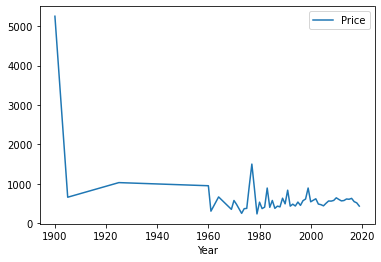

In [59]:
data_duplicate_removed.groupby('Year').agg({'Price':'mean'}).plot()

##### Conclusion:
                Between 1900 to 1960 there are few points is there thatz why a straight line.
                Price range is same from 1900 to 2020. 
                Not getting enough inforamation according to year about price from this plot.

#### PDF of Year column

<AxesSubplot:xlabel='Year', ylabel='Density'>

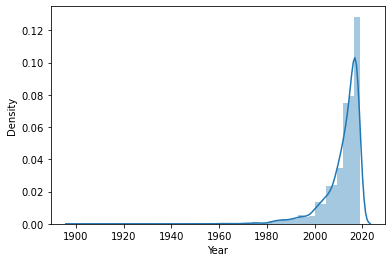

In [60]:
sns.distplot(data_duplicate_removed['Year'])

#### Conclusion:
                data is skewed.
                Not getting enough inforamation.

#### Creating new Month column from New_Date column.

In [61]:
data_duplicate_removed['Month'] = data_duplicate_removed['New_Date'].dt.month

#### Plot Month vs Price

##### Checking if Month column make any impact on Price column

<AxesSubplot:xlabel='Month'>

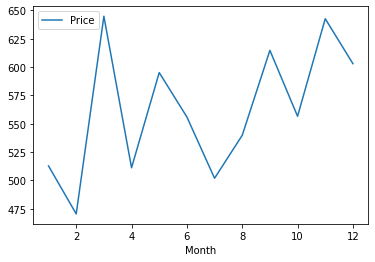

In [62]:
data_duplicate_removed.groupby('Month').agg({'Price':'mean'}).plot()

### Text cleaning on Synopsis column

In [64]:
data_duplicate_removed['Synopsis'][500]

"Python is the most popular programming language for beginners because it's fun, powerful, and easy to learn. So why should your introductory Python book be long and tedious?\n\nPython Crash Course gets you up and running with Python, teaching you the basics quickly so that you can solve problems, make things, and do cool stuff. Each chapter explains a new programming concept and includes a set of exercises to help reinforce your new knowledge.\n\nBut most important of all, Python Crash Course includes three hands-on projects to put your new programming skills into practice, so it's not just syntax and theory. You'll learn how to create a simple video game, use data visualization techniques to make interactive graphs and charts, and build a simple Web application. Python Crash Course teaches you Python the fun way—it's quick, hands-on, and totally useful."

#### Creating new column count_synopsis from Synopsis to count total words.

In [65]:
data_duplicate_removed['count_synopsis'] = data_duplicate_removed['Synopsis'].str.split().str.len()

##### PDF of count_synopsis

<AxesSubplot:xlabel='count_synopsis', ylabel='Density'>

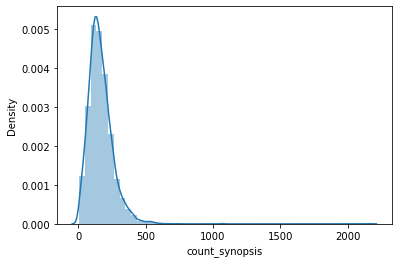

In [66]:
sns.distplot(data_duplicate_removed['count_synopsis'])

In [67]:
data_duplicate_removed.corr()

,Reviews,Ratings,Price,Year,Month,count_synopsis
Reviews,1.000000,0.132796,-0.159277,-0.011751,0.014679,0.045176
Ratings,0.132796,1.000000,-0.076663,0.015086,-0.005982,0.138665
Price,-0.159277,-0.076663,1.000000,-0.021017,0.033664,0.035901
Year,-0.011751,0.015086,-0.021017,1.000000,-0.005814,0.110911
Month,0.014679,-0.005982,0.033664,-0.005814,1.000000,-0.001493
count_synopsis,0.045176,0.138665,0.035901,0.110911,-0.001493,1.000000


In [68]:
stopwords_custom= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y']

In [69]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import nltk

lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}

def lemmatize_words(text):
    
    pos_tagged_text = nltk.pos_tag(text.split())
    #print(pos_tagged_text)
    
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

In [70]:
def clean_text(sentence):
    sentence = sentence.lower()
    
    sentence = re.sub(r'^https?:\/\/.*[\r\n]*', '', sentence, flags=re.MULTILINE)
    sentence = re.sub(r'<[^>]*>','',sentence)
    sentence = re.sub(r'\S*@\S*\s?','',sentence)
    sentence = re.sub(r'[-]+',' ',sentence)
    sentence = ' '.join([word for word in sentence.split() if word not in stopwords_custom])
    sentence = re.sub(r'[^\w\s]','',sentence)
    sentence = re.sub(r'[^a-z ]+','',sentence)
    sentence = re.sub(r'\\b[a-z]\\b','', sentence)
    sentence = re.sub(r'[\s]+', ' ',sentence)
    sentence = lemmatize_words(sentence)
    
    return sentence

In [71]:
data_duplicate_removed['clean_synopsis'] = data_duplicate_removed['Synopsis'].apply(clean_text)

In [72]:
data_duplicate_removed['clean_synopsis'][34]

'journey alongside nathan drake again naughty dog dark horse book team bring comprehensive breathtaking exploration uncharted thiefs end numerous never see design concept art accompany commentary developer give behind scene access creation game masterwork beautiful oversized hardcover must fan uncharted franchise high quality video game art art unchartend release dark horse simultaneoulsy new game uncharted'

#### Creating new column AgeoftheBook from Year column to check how old is the book and impact on the price

In [74]:
data_duplicate_removed['AgeoftheBook'] = 2022 - data_duplicate_removed['Year']

In [75]:
np.isnan(2022 - data_duplicate_removed['Year']).any()

True

#### TrainTest split

In [77]:
from sklearn.model_selection import train_test_split

In [78]:
X = data_duplicate_removed.drop(columns = ['Price'])
y = data_duplicate_removed['Price']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = .15,random_state = 42)

In [79]:
X_train.shape

(4765, 17)

In [80]:
X_test.shape

(841, 17)

## Label Encoding

#### NewGenre

In [81]:
new_genre_labelencoder = LabelEncoder()
x_train_newgenre_encoded = new_genre_labelencoder.fit_transform(X_train['NewGenre'])
x_test_newgenre_encoded = new_genre_labelencoder.transform(X_test['NewGenre'])

##### BookCategory

In [82]:
bookcategory_labelencoder = LabelEncoder()
x_train_bookcategory_encoded = bookcategory_labelencoder.fit_transform(X_train['BookCategory'])
x_test_bookcategory_encoded = bookcategory_labelencoder.transform(X_test['BookCategory'])

#### Type

In [83]:
type_labelencoder = LabelEncoder()
x_train_type_encoded = type_labelencoder.fit_transform(X_train['Type'])
x_test_type_encoded = type_labelencoder.transform(X_test['Type'])

#### Vectorization on text column clean_synopsis

In [84]:
tfidf = TfidfVectorizer(max_features = 2000 )
X_train_tfidf = tfidf.fit_transform(X_train['clean_synopsis'])
X_test_tfidf = tfidf.transform(X_test['clean_synopsis'])

In [85]:
X_train_tfidf.shape

(4765, 2000)

In [86]:
X_test_tfidf.shape

(841, 2000)

#### checking if X_train_stack contain nan values

In [255]:
np.isnan(X_train['Year']).any()

False

In [256]:
np.isnan(X_train['Year']).sum()
#X_train[pd.isnull(X_train['Year'])]

0

#### impute nan with mode in Year column

In [213]:
year_mode = X_train['Year'].mode().iloc[0]
year_mode

2018.0

In [93]:
X_train['Year'] = X_train['Year'].replace(np.nan,year_mode)
X_test['Year'] = X_test['Year'].replace(np.nan,year_mode)

#### impute nan with mode in ageoftheBook column

In [94]:
mode_AgeoftheBook = X_train['AgeoftheBook'].mode().iloc[0]
mode_AgeoftheBook

4.0

In [95]:
X_train['AgeoftheBook'] = X_train['AgeoftheBook'].replace(np.nan,mode_AgeoftheBook)
X_test['AgeoftheBook'] = X_test['AgeoftheBook'].replace(np.nan,mode_AgeoftheBook)

### stacking after label encdoing
#####        1. labelencoded columns(x_train_newgenre_encoded,x_train_bookcategory_encoded,x_train_type_encoded reshaping by (-1,1) all these columns to get in 2-D shape),
#####         2. Review,Ratings,Year columns(All this 3 column are series so by using .values getting np array and reshaping by (-1,1) to get this in 2-D shape).

In [164]:
X_train_stack = np.hstack([x_train_newgenre_encoded.reshape(-1,1),x_train_bookcategory_encoded.reshape(-1,1),x_train_type_encoded.reshape(-1,1),X_train['Ratings'].values.reshape(-1,1),X_train['Reviews'].values.reshape(-1,1),X_train['AgeoftheBook'].values.reshape(-1,1),X_train_tfidf.toarray()])
X_test_stack = np.hstack([x_test_newgenre_encoded.reshape(-1,1),x_test_bookcategory_encoded.reshape(-1,1),x_test_type_encoded.reshape(-1,1),X_test['Ratings'].values.reshape(-1,1),X_test['Reviews'].values.reshape(-1,1),X_test['AgeoftheBook'].values.reshape(-1,1),X_test_tfidf.toarray()])                        

### one hot encoding

##### Bookcategory

In [97]:
bookcategory_ohe = OneHotEncoder()
x_train_bookcategory_ohe = bookcategory_ohe.fit_transform(X_train['BookCategory'].values.reshape(-1,1))
x_test_bookcategory_ohe = bookcategory_ohe.transform(X_test['BookCategory'].values.reshape(-1,1))

##### Type

In [143]:
type_ohe = OneHotEncoder()
x_train_type_ohe = type_ohe.fit_transform(X_train['Type'].values.reshape(-1,1))
x_test_type_ohe = type_ohe.transform(X_test['Type'].values.reshape(-1,1))

##### NewGenre

In [99]:
newgenre_ohe = OneHotEncoder()
x_train_newgenre_ohe = newgenre_ohe.fit_transform(X_train['NewGenre'].values.reshape(-1,1))
x_test_newgenre_ohe = newgenre_ohe.transform(X_test['NewGenre'].values.reshape(-1,1))

### Powertransformer

In [188]:
pt = PowerTransformer()

##### Ratings

In [191]:
x_train_transform_Ratings = pt.fit_transform(X_train['Ratings'].values.reshape(-1,1))
x_test_transform_Ratings = pt.transform(X_test['Ratings'].values.reshape(-1,1))

##### Reviews

In [192]:
x_train_transform_Reviews = pt.fit_transform(X_train['Reviews'].values.reshape(-1,1))
x_test_transform_Reviews = pt.transform(X_test['Reviews'].values.reshape(-1,1))

#### AgeoftheBook

In [193]:
x_train_transform_AgeoftheBook = pt.fit_transform(X_train['AgeoftheBook'].values.reshape(-1,1))
x_test_transform_AgeoftheBook = pt.transform(X_test['AgeoftheBook'].values.reshape(-1,1))

### Stacking after powertransformer

In [198]:
X_train_stack_transform = np.hstack([x_train_newgenre_ohe.toarray(),x_train_type_ohe.toarray(),x_train_bookcategory_ohe.toarray(),x_train_transform_Ratings,x_train_transform_Reviews,x_train_transform_AgeoftheBook,X_train_tfidf.toarray()])
X_test_stack_transform = np.hstack([x_test_newgenre_ohe.toarray(),x_test_type_ohe.toarray(),x_test_bookcategory_ohe.toarray(),x_test_transform_Ratings,x_test_transform_Reviews,x_test_transform_AgeoftheBook,X_test_tfidf.toarray()])                        

### Standrard scaling after powertransform

In [199]:
scaled_features_transform = StandardScaler()
X_train_scaled_transform = scaled_features.fit_transform(X_train_stack_reducedcol)
X_test_scaled_transform = scaled_features.transform(X_test_stack_reducedcol)

### Stacking after one hot encoding

In [196]:
X_train_stack_reducedcol = np.hstack([x_train_newgenre_ohe.toarray(),x_train_type_ohe.toarray(),x_train_bookcategory_ohe.toarray(),X_train['Ratings'].values.reshape(-1,1),X_train['Reviews'].values.reshape(-1,1),X_train['AgeoftheBook'].values.reshape(-1,1),X_train_tfidf.toarray()])
X_test_stack_reducedcol = np.hstack([x_test_newgenre_ohe.toarray(),x_test_type_ohe.toarray(),x_test_bookcategory_ohe.toarray(),X_test['Ratings'].values.reshape(-1,1),X_test['Reviews'].values.reshape(-1,1),X_test['AgeoftheBook'].values.reshape(-1,1),X_test_tfidf.toarray()])                        

### standrard scaling after one hot encoding

In [157]:
scaled_features = StandardScaler()
X_train_scaled = scaled_features.fit_transform(X_train_stack_reducedcol)
X_test_scaled = scaled_features.transform(X_test_stack_reducedcol)

In [155]:
X_train_scaled.shape

(4765, 2037)

### Model building

#### KNN regression

In [124]:
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)
knn_pred = knn_model.predict(X_test_scaled)

In [125]:
def price_score(y_true,y_pred):
    return 1 - np.sqrt(np.square(np.log10(y_pred +1) - np.log10(y_true +1)).mean())

In [126]:
price_score(y_test,knn_pred)

0.672166340204004

In [127]:
mean_squared_error(y_test,knn_pred)

524912.8271044662

In [128]:
scorer = make_scorer(price_score, greater_is_better=False)
scorer

make_scorer(price_score, greater_is_better=False)

#### KNN Hyperparameter tuning

In [ ]:
knn_cv = KNeighborsRegressor()
param_grid_knn = {'n_neighbors':[15,20,21,23,24,29,30,35],'weights':['uniform','distance']}

knn_search = GridSearchCV(estimator=knn_cv, param_grid=param_grid_knn,scoring =scorer,n_jobs=-1,cv=5,verbose=1)

knn_search.fit(X_train_scaled,y_train)

In [ ]:
knn_search.best_score_

In [ ]:
knn_search.best_params_

In [ ]:
knn_search.best_estimator_

### Linear regression

In [129]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled,y_train)
lr_pred = lr_model.predict(X_test_scaled)

In [130]:
price_score(y_test,lr_pred)

0.5419149437457995

In [131]:
mean_squared_error(y_test,lr_pred)

637579.8339722592

### SVR

In [132]:
svr_model = SVR()
svr_model.fit(X_train_scaled,y_train)
svr_pred = svr_model.predict(X_test_scaled)

In [133]:
price_score(y_test,svr_pred)

0.6623994490353332

In [134]:
mean_squared_error(y_test,svr_pred)

588795.561663347

#### SVR Hyperparameter tuning

In [ ]:
svc_cv = SVR()
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'degree':[2,3,5],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'epsilon': [0.1,0.2,0.3]} 
grid = RandomizedSearchCV(svc_cv, param_grid,scoring =scorer, n_iter = 5,cv = 2,verbose = 1)
grid.fit(X_train_scaled, y_train)

In [ ]:
grid.best_params_

In [ ]:
grid.best_score_

In [ ]:
grid.best_estimator_

#### Decision Tree Regressor

In [135]:
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train_scaled,y_train)
dt_pred = dt_model.predict(X_test_scaled)

In [136]:
price_score(y_test,dt_pred)

0.6374477830181338

In [137]:
mean_squared_error(y_test,dt_pred)

818854.17648371

#### DT regrrssor Hyperparameter

In [116]:
dtr_hyperpara = DecisionTreeRegressor()

param_grid = { "max_depth" : [1,3,5,7,9,11,12],
           #"min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           #"min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
           "max_features":["auto","log2","sqrt",None],
          # "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90]
    }

grid_dtr = GridSearchCV(estimator = dtr_hyperpara ,param_grid = param_grid, n_jobs = -1,cv = 3,scoring = scorer)
grid_dtr.fit(X_train_scaled,y_train)

GridSearchCV(cv=3, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [1, 3, 5, 7, 9, 11, 12],
                         'max_features': ['auto', 'log2', 'sqrt', None],
                         'max_leaf_nodes': [None, 10, 20, 30, 40, 50, 60, 70,
                                            80, 90],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'min_weight_fraction_leaf': [0.1, 0.2, 0.3, 0.4, 0.5,
                                                      0.6, 0.7, 0.8, 0.9],
                         'splitter': ['best', 'random']},
             scoring=make_scorer(price_score, greater_is_better=False))

In [117]:
grid_dtr.best_score_

-0.6328982621504528

In [118]:
grid_dtr.best_estimator_

DecisionTreeRegressor(max_depth=3, max_features='log2', max_leaf_nodes=80,
                      min_samples_leaf=7, min_weight_fraction_leaf=0.2,
                      splitter='random')

#### Random forest regressor

In [165]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train_scaled,y_train)
rf_pred = rf_model.predict(X_test_scaled)

In [166]:
price_score(y_test,rf_pred)

0.7163289542353981

In [141]:
mean_squared_error(y_test,rf_pred)

688.1370151046721

#### Hyperparameter tuning for RF

In [262]:
rf_para = RandomForestRegressor()
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
grid_rf = GridSearchCV(estimator = rf_para, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2,scoring = scorer)
grid_rf.fit(X_train_scaled,y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300, 1000]},
             scoring=make_scorer(price_score, greater_is_better=False),
             verbose=2)

In [263]:
grid_rf.best_score_

-0.656833015791321

### RF With powertransformer and standrard scaling

In [250]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train_scaled_transform,y_train)
rf_pred_transform_scaled = rf_model.predict(X_test_scaled_transform)

In [251]:
price_score(y_test,rf_pred_transform_scaled)

0.718869340173703

### RF with powertransformer without standrard scaling

In [202]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train_stack_transform,y_train)
rf_pred_transform = rf_model.predict(X_test_stack_transform)

In [203]:
price_score(y_test,rf_pred_transform)

0.7158483242577673

## Generating prediction on test data

In [264]:
test_data = pd.read_excel('Data_Test.xlsx')
test_data.head(2)

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory
0,The Complete Sherlock Holmes: 2 Boxes sets,Sir Arthur Conan Doyle,"Mass Market Paperback,– 1 Oct 1986",4.4 out of 5 stars,960 customer reviews,A collection of entire body of work of the She...,Short Stories (Books),"Crime, Thriller & Mystery"
1,Learn Docker - Fundamentals of Docker 18.x: Ev...,Gabriel N. Schenker,"Paperback,– Import, 26 Apr 2018",5.0 out of 5 stars,1 customer review,Enhance your software deployment workflow usin...,Operating Systems Textbooks,"Computing, Internet & Digital Media"


In [206]:
test_data_duplicate_removed = test_data.drop_duplicates(subset = ['Title','Author','Edition'])

In [208]:
test_data_duplicate_removed[['Type','Date']] = test_data_duplicate_removed['Edition'].str.split(',– ',expand=True)

In [225]:
test_data_duplicate_removed['Type'] = test_data_duplicate_removed['Type'].replace(reverse_dict)

In [238]:
test_data_duplicate_removed['NewGenre'] = test_data_duplicate_removed['Genre'].replace(new_genre)

In [211]:
test_data_duplicate_removed['New_Date'] = test_data_duplicate_removed['Date'].apply(lambda x: myparser(x))

In [212]:
test_data_duplicate_removed['Year'] = test_data_duplicate_removed['Date'].apply(extract_year)

In [214]:
test_data_duplicate_removed['Year'] = test_data_duplicate_removed['Year'].replace(np.nan,year_mode)

In [215]:
test_data_duplicate_removed['AgeoftheBook'] = 2022 - test_data_duplicate_removed['Year']

In [241]:
test_data_duplicate_removed['clean_synopsis'] = test_data_duplicate_removed['Synopsis'].apply(clean_text)

In [216]:
test_data_duplicate_removed['Ratings'] = pd.to_numeric(test_data_duplicate_removed['Ratings'].str.strip(' customer reviews').str.replace(',',''))

In [217]:
test_data_duplicate_removed['Reviews'] = pd.to_numeric(test_data_duplicate_removed['Reviews'].str.strip(' out of 5 stars'))

In [218]:
test_bookcategory_ohe = bookcategory_ohe.transform(test_data_duplicate_removed['BookCategory'].values.reshape(-1,1))

In [226]:
test_type_ohe = type_ohe.transform(test_data_duplicate_removed['Type'].values.reshape(-1,1))

In [239]:
test_newgenre_ohe =newgenre_ohe.transform(test_data_duplicate_removed['NewGenre'].values.reshape(-1,1))

In [242]:
test_tfidf = tfidf.transform(test_data_duplicate_removed['clean_synopsis'])

In [243]:
test_transform_Ratings = pt.transform(test_data_duplicate_removed['Ratings'].values.reshape(-1,1))

In [244]:
test_transform_Reviews = pt.transform(test_data_duplicate_removed['Reviews'].values.reshape(-1,1))

In [246]:
test_transform_AgeoftheBook = pt.transform(test_data_duplicate_removed['AgeoftheBook'].values.reshape(-1,1))

In [248]:
test_stack_transform = np.hstack([test_newgenre_ohe.toarray(),test_type_ohe.toarray(),test_bookcategory_ohe.toarray(),test_transform_Ratings,test_transform_Reviews,test_transform_AgeoftheBook,test_tfidf.toarray()])                        

In [249]:
test_scaled_transform = scaled_features.transform(test_stack_transform)

In [253]:
pred_data = pd.DataFrame(rf_model.predict(test_scaled_transform),columns =['Price'])
pred_data

,Price
0,563.1603
1,1369.6000
2,426.7961
3,1006.8564
4,399.1614
...,...
1516,778.6172
1517,437.8276
1518,491.4544
1519,607.7771


In [254]:
pred_data.to_csv('Submission.csv',index = False)